# Real Time Eye Gaze Tracking with Kinect


In [1]:
from PIL import Image
import cv2
import numpy as np
import os
import json
import pandas as pd
import bson
from tqdm import tqdm
from pprint import pprint
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline

import sys
sys.path.append('../')

from brspy.export import GazesExport
from brspy.export import MimicsExport
from brspy.export import JointsExport
from brspy.export import JointOrientationsExport
from brspy.export import FacePropertiesExport

from brspy.reader import Session
from utils import *

from devices import Camera
from devices import Device

import plotly.plotly as py
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

from pyquaternion import Quaternion

## Configuration

In [182]:
# markers_path = r'./markers.json'
markers_path = r'./dots.json'
# datasets_path = r"./datasets/07_08_18"

datasets_path = r"D:/datasets-calibration/14_08_18"
sess_path = os.path.join(datasets_path, '1534255495')
# valik
test_sess_path = r"D:/datasets-calibration/16_08_18/1534426982"
# "D:/datasets-calibration/15_08_18/1534348495" # 1534255495
cam_data_path = r'./cam_data.json'

with open(markers_path, 'r') as f:
    markers_db = json.load(f)
    
with open(cam_data_path, 'r') as f:
    cam_data = json.load(f)
    
avg_eye_radius = 0.007462746808244293

### Cameras 

In [3]:
for cam_name, data_dict in cam_data.items():
    Camera(cam_name, **data_dict)
    
KinectColor = Camera.get('KinectColor')
WebCamera = Camera.get('WebCamera')
InfraredCamera = Camera.get('InfraredCamera')
KinectInfrared = Camera.get('KinectInfrared')

### write markers to session

In [11]:
markers_path = r'./dots.json'
markers_save = os.path.join(sess_path, 'DataSource', 'cam_101')

try:
    os.mkdir(markers_save)
except:
    pass

with open(markers_path, 'r') as f:
    markers_db = json.load(f)
    
counter = 0
for i in range(9):
    for j in range(100):
        marker = markers_db.get(f'screen_dot_{i+1}')
        if marker:
            file_name = os.path.join(markers_save, str(counter).rjust(5, '0') + '.txt')
            with open(file_name, 'w') as f:
                json.dump(to_json(marker, scale=1e-3), f)
            counter += 1

In [5]:
# choose only wall 0
markers_wall_0 = {key: value for key, value in markers_db.items() if key.split('_')[1] == '0'}
pprint(markers_wall_0)

markers_save = os.path.join(sess_path, 'DataSource', 'cam_101')

try:
    os.mkdir(markers_save)
except:
    pass

counter = 0
for i in range(5):
    for j in range(8):
        marker = markers_wall_0.get(f'wall_{0}_dot_{j+1}')
        if marker:
            file_name = os.path.join(markers_save, str(counter).rjust(5, '0') + '.txt')
            with open(file_name, 'w') as f:
                json.dump(to_json(marker), f)
            counter += 1

{'wall_0_dot_1': [1.2878455803398767, -1.4462872524020634, -2.0433796750522086],
 'wall_0_dot_2': [0.3235454220662274, -1.4403578997805284, -2.0905758046738723],
 'wall_0_dot_3': [-0.4954355512992749,
                  -1.4353220953790173,
                  -2.1306595191117434],
 'wall_0_dot_4': [-1.5241555544291134,
                  -1.4289966337527293,
                  -2.1810085750519956],
 'wall_0_dot_5': [1.2919249781934634, -0.4471771977434076, -2.0018112330072593],
 'wall_0_dot_6': [0.32762481991981407,
                  -0.44124784512187254,
                  -2.0490073626289234],
 'wall_0_dot_7': [-0.4913561534456882, -0.4362120407203617, -2.089091077066794],
 'wall_0_dot_8': [-1.5200761565755267,
                  -0.42988657909407363,
                  -2.1394401330070463]}


## Create session

In [183]:
sess = Session(sess_path)
test_sess = Session(test_sess_path)

device_to_remove = [
#     'KinectDepth',
#     'KinectInfrared',
#     'KinectBodyIndex',
#     'KinectColor',
#     'KinectBody',
#     'KinectFaceVertices',
#     'GazeEstimation',
#     'WebCamera',
#     'InfraredCamera',
#     'Markers'
]

# sess.remove_devices(*device_to_remove)

### analyse snapshot

In [5]:
def estimate_face_points_3d(snapshot, camera, cam_resolution_x=1296):
    
    pipe_left = make_pipeline(PolynomialFeatures(degree=9), Ridge(1e-9))
    pipe_right = make_pipeline(PolynomialFeatures(degree=9), Ridge(1e-9))
    
    # get face points
    face_points = np.array([dict_to_np(snapshot.KinectFaceVertices[str(i)]).flatten() for i in HDFace.All])
    face_points = face_points * flip_array
    
    # get eye circle points
    RightEyeInnerLid = InfraredCamera.vectors_to_self(face_points[HDFace.RightEyeInnerLid])
    LeftEyeInnerLid = InfraredCamera.vectors_to_self(face_points[HDFace.LeftEyeInnerLid])
    
    # get pupil center on 2D image
    pupil_left_2d = dict_to_np(snapshot.GazeEstimation['pupilCenterLeft'])
    pupil_right_2d = dict_to_np(snapshot.GazeEstimation['pupilCenterRight'])
    
    # or get manually mapped points
#     pupil_left_2d = dict_to_np(snapshot.ManualPupils['pupilCenterLeft'])
#     pupil_right_2d = dict_to_np(snapshot.ManualPupils['pupilCenterRight'])
    
    # get roi points of eye
    roi_left = np.array([dict_to_np(roi_pt)[0] for roi_pt in snapshot.GazeEstimation['eyeRoiLeft']])
    roi_right = np.array([dict_to_np(roi_pt)[0] for roi_pt in snapshot.GazeEstimation['eyeRoiRight']])
    
    # flip x-coordinate of 2D coordinates because of mirrored image
    pupil_left_2d[0, 0] = cam_resolution_x - pupil_left_2d[0, 0]
    pupil_right_2d[0, 0] = cam_resolution_x - pupil_right_2d[0, 0]
    roi_left[:, 0] = cam_resolution_x - roi_left[:, 0]
    roi_right[:, 0] = cam_resolution_x - roi_right[:, 0]
    
    # calculate relative position of pupil center on 2D image
    relative_pupil_left_2d = (pupil_left_2d - roi_left[0]) / np.diff(roi_left, axis=0)
    relative_pupil_right_2d = (pupil_right_2d - roi_right[0]) / np.diff(roi_right, axis=0)
    relative_pupil_left_2d[0, 0] = 1 - relative_pupil_left_2d[0, 0] 
    relative_pupil_right_2d[0, 0] = 1 - relative_pupil_right_2d[0, 0] 
    
    # estimate eye surface
    left_XY = LeftEyeInnerLid[:, :2]
    left_Z = LeftEyeInnerLid[:, 2]
    right_XY = RightEyeInnerLid[:, :2]
    right_Z = RightEyeInnerLid[:, 2]
    
    pipe_left.fit(left_XY, left_Z)
    pipe_right.fit(right_XY, right_Z)
    
    # get eye corners, top and mid points
    # and transit to Interested Camera coordinate system
    left_inner = camera.vectors_to_self(face_points[HDFace.LeftEyeInnercorner].reshape(1, 3)).flatten()
    left_outer = camera.vectors_to_self(face_points[HDFace.LeftEyeOutercorner].reshape(1, 3)).flatten()
    left_midtop = camera.vectors_to_self(face_points[HDFace.LeftEyeMidtop].reshape(1, 3)).flatten()
    left_midbot = camera.vectors_to_self(face_points[HDFace.LeftEyeMidbottom].reshape(1, 3)).flatten()
    
    right_inner = camera.vectors_to_self(face_points[HDFace.RightEyeInnercorner].reshape(1, 3)).flatten()
    right_outer = camera.vectors_to_self(face_points[HDFace.RightEyeOutercorner].reshape(1, 3)).flatten()
    right_midtop = camera.vectors_to_self(face_points[HDFace.RightEyeMidtop].reshape(1, 3)).flatten()
    right_midbot = camera.vectors_to_self(face_points[HDFace.RightEyeMidbottom].reshape(1, 3)).flatten()
    
    # get roi points X and Y in 3D in Interested Camera coordinate system
    left_top = np.array([left_inner[0], left_midtop[1]])
    left_bot = np.array([left_outer[0], left_midbot[1]])
    
    right_bot = np.array([right_inner[0], right_midbot[1]])
    right_top = np.array([right_outer[0], right_midtop[1]])
    
    # get size of roi 3 roi
    left_size_xy = np.abs(left_top - left_bot)
    right_size_xy = np.abs(right_top - right_bot)

    # estimate X and Y of 3D pupilcenter
    pupil_left_XY = left_top + relative_pupil_left_2d * left_size_xy
    pupil_right_XY = right_top + relative_pupil_right_2d * right_size_xy
    
    # estimate Z of 3D pupil_center
    pupil_left_Z = pipe_left.predict(pupil_left_XY)
    pupil_left_XYZ = np.column_stack((pupil_left_XY, pupil_left_Z))
    
    pupil_right_Z = pipe_right.predict(pupil_right_XY)
    pupil_right_XYZ = np.column_stack((pupil_right_XY, pupil_right_Z))
    
    # return pupil_center to origin coordinate system
    pupil_left_center = camera.vectors_to_origin(pupil_left_XYZ)
    pupil_right_center = camera.vectors_to_origin(pupil_right_XYZ)
    
    return face_points, pupil_left_center, pupil_right_center

In [190]:
markers = []

rotations, translations = [], []

left_pupil_centers, right_pupil_centers = [], []
left_gazes_true, right_gazes_true = [], []
left_eye_centers, right_eye_centers = [], []

face_points_array = []

pipe_left = make_pipeline(PolynomialFeatures(degree=9), Ridge(1e-9))
pipe_right = make_pipeline(PolynomialFeatures(degree=9), Ridge(1e-9))

frames = []

flip_array = np.array([-1, -1, 1])

for snapshot in test_sess.snapshots_iterate(240, 240+9*10, verbose=True):
    
    # get pupil and face points
    face_points, left_pupil_center, right_pupil_center = estimate_face_points_3d(snapshot, InfraredCamera)
    
    # get translation and rotation of head
    translation = dict_to_np(snapshot.KinectBody['0']['Joints']['Head']['Position']).flatten() * flip_array
#     rotation = quaternion_to_rotation(snapshot.KinectFace[0]['FaceRotationQuaternion']) #* np.array([1, 1, 1])
    q = snapshot.KinectFace[0]['FaceRotationQuaternion']
    q = Quaternion(q['W'], q['X'], q['Y'], q['Z'])
    rotation = cv2.Rodrigues(q.rotation_matrix)[0].flatten() #* np.array([1, 1, 1])
    
    # get marker
#     marker = dict_to_np(snapshot.Markers) 
    
    # create person device
    person = Device(name='person', translation=translation.tolist(), rotation=rotation.tolist())
    
    # get eye centers
    left_eye_center = dict_to_np(snapshot.GazeEstimation['eyeSphereCenterLeft']) * flip_array
    right_eye_center = dict_to_np(snapshot.GazeEstimation['eyeSphereCenterRight']) * flip_array
    
    ### append data ###
    
    # pupils
    left_pupil_centers.append(left_pupil_center.flatten())
    right_pupil_centers.append(right_pupil_center.flatten())
    
    # head position
    rotations.append(rotation)
    translations.append(translation)
    
    # markers
#     markers.append(marker.flatten())
    
    # face points
    face_points_array.append(face_points)
    
    # eye centers
    left_eye_centers.append(left_eye_center.flatten())
    right_eye_centers.append(right_eye_center.flatten())
    
    # face vector for visualization
    faceGaze = np.array([translation.flatten(), (translation - 4 * rotation).flatten()])
    
left_pupil_centers = np.array(left_pupil_centers)
right_pupil_centers = np.array(right_pupil_centers)

rotations = np.array(rotations)
translations = np.array(translations)
markers = np.array(markers)

face_points_array = np.array(face_points_array)

left_eye_centers = np.array(left_eye_centers)
right_eye_centers = np.array(right_eye_centers)

100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.05it/s]


In [93]:
markers_self = vectors_to(markers, rotations, translations, to='self') 
right_pupil_centers_self = vectors_to(right_pupil_centers, rotations, translations, to='self')

right_gazes_true_self_test = markers_self - right_pupil_centers_self
right_gazes_true_self_test = right_gazes_true_self_test / np.linalg.norm(right_gazes_true_self_test, axis=1, keepdims=True)

right_gazes_true_self = vectors_to(right_gazes_true, rotations, to='self')
right_gazes_true_self_test - right_gazes_true_self

array([[ 0.00000000e+00,  5.55111512e-17,  0.00000000e+00],
       [-8.32667268e-17,  5.55111512e-17,  1.11022302e-16],
       [-2.77555756e-17,  5.55111512e-17,  2.22044605e-16],
       ...,
       [ 4.16333634e-17,  6.93889390e-18,  0.00000000e+00],
       [ 1.04083409e-17,  3.46944695e-18, -1.11022302e-16],
       [-5.55111512e-17,  1.73472348e-18,  1.11022302e-16]])

In [192]:
# # calculate true gazes in origin CS
# right_gazes_true = markers - right_pupil_centers
# right_gazes_true = right_gazes_true / np.linalg.norm(right_gazes_true, axis=1, keepdims=True)

# left_gazes_true = markers - left_pupil_centers
# left_gazes_true = left_gazes_true / np.linalg.norm(left_gazes_true, axis=1, keepdims=True)

# calculate pupil vectors
right_pupil_vectors = right_pupil_centers - right_eye_centers
left_pupil_vectors = left_pupil_centers - left_eye_centers

# norm pupil vectors
right_pupil_vectors = right_pupil_vectors / np.linalg.norm(right_pupil_vectors, axis=1, keepdims=True)
left_pupil_vectors = left_pupil_vectors / np.linalg.norm(left_pupil_vectors, axis=1, keepdims=True)

In [88]:
def create_trace_3d(data, **kwargs):
    
    assert data.ndim == 2
    assert data.shape[1] == 3
    
    x, y, z = data.T
    return go.Scatter3d(x=x, y=z, z=-y, **kwargs)

marker_style={
    'mode': 'markers',
    'marker': dict(size=3, line=dict(color='rgba(217, 217, 217, 0.14)', width=0.5), opacity=0.8)
}

line_style={
#     'mode': 'line',
    'marker': dict(size=3, line=dict(color='rgba(217, 217, 217, 0.14)', width=0.5), opacity=0.8)
}

In [89]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import FunctionTransformer

# # with rotation and translation
# X_right = np.column_stack((right_pupil_centers, right_eye_centers, rotations, translations))
# Y_right = vecs2angles(right_gazes_true)

# X_left = np.column_stack((left_pupil_centers, left_eye_centers, rotations, translations))
# Y_left = vecs2angles(left_gazes_true)

# without rotation and translation

right_pupil_vectors_self = vectors_to(right_pupil_vectors, rotations, to='self')
left_pupil_vectors_self = vectors_to(left_pupil_vectors, rotations, to='self')
Y_right = right_gazes_true_self = vecs2angles(vectors_to(right_gazes_true, rotations, to='self'))
Y_left = left_gazes_true_self = vecs2angles(vectors_to(left_gazes_true, rotations, to='self'))

X_right = np.column_stack((right_pupil_vectors_self, left_pupil_vectors_self * np.array([-1, 1, 1]), rotations)) 
X_left = np.column_stack((left_pupil_vectors_self, right_pupil_vectors_self * np.array([-1, 1, 1]), rotations)) 


poly_features = 3
alpha = 1e-3
model = Ridge(alpha)

pipe_gaze_right = make_pipeline(PolynomialFeatures(poly_features), model)
pipe_gaze_left = make_pipeline(PolynomialFeatures(poly_features), model)
kf = KFold(20)


pipes_gaze_right = []
pipes_gaze_left = []

left_angle_errs = []
right_angle_errs = []
for i, (train_index, test_index) in enumerate(kf.split(X_left)):
    
    # fit
    pipe_gaze_right.fit(X_right[train_index], Y_right[train_index])
    pipe_gaze_left.fit(X_left[train_index], Y_left[train_index])
    
    
    pipes_gaze_right.append(pipe_gaze_right)
    pipes_gaze_left.append(pipe_gaze_left)
    
    # test
    Y_pred_right = pipe_gaze_right.predict(X_right[test_index])
    Y_pred_left = pipe_gaze_left.predict(X_left[test_index])    
    
    left_angle_err = calc_angle_spherical(Y_pred_left, Y_left[test_index])
    right_angle_err = calc_angle_spherical(Y_pred_right, Y_right[test_index])
    
    left_angle_errs.append(left_angle_err)
    right_angle_errs.append(right_angle_err)
    print('===========')
    print(f'i: {i} Test point {test_index} \n\tleft: {left_angle_err.mean()},\n\tright: {right_angle_err.mean()}')
    
left_angle_errs = np.array(left_angle_errs)
right_angle_errs = np.array(right_angle_errs)

print(left_angle_errs.mean(), right_angle_errs.mean())

i: 0 Test point [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44] 
	left: 6.137462801101576,
	right: 23.452111127200517
i: 1 Test point [45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68
 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89] 
	left: 5.955146585039538,
	right: 9.661346887610401
i: 2 Test point [ 90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134] 
	left: 6.546125016553981,
	right: 19.805742043503766
i: 3 Test point [135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179] 
	left: 9.221942302540688,
	right: 22.347532742504054
i: 4 Test point [180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 

In [193]:
# pipe_gaze_right.fit(X_right[train_index], Y_right[train_index])
# pipe_gaze_left.fit(X_left[train_index], Y_left[train_index])

right_gazes_pred = angles2vecs(pipes_gaze_right[4].predict(X_right))
left_gazes_pred = angles2vecs(pipes_gaze_left[4].predict(X_left))

In [194]:
# with rotation and translation
# without rotation and translation

right_pupil_vectors_self = vectors_to(right_pupil_vectors, rotations, to='self')
left_pupil_vectors_self = vectors_to(left_pupil_vectors, rotations, to='self')
# Y_test_right = right_gazes_true_self = vecs2angles(vectors_to(right_gazes_true, rotations, to='self'))
# Y_test_left = left_gazes_true_self = vecs2angles(vectors_to(left_gazes_true, rotations, to='self'))

X_test_right = np.column_stack((right_pupil_vectors_self, left_pupil_vectors_self * np.array([-1, 1, 1]), rotations)) 
X_test_left = np.column_stack((left_pupil_vectors_self, right_pupil_vectors_self * np.array([-1, 1, 1]), rotations)) 

right_gazes_pred = vectors_to(angles2vecs(pipes_gaze_right[8].predict(X_test_right)), rotations, to='origin')
left_gazes_pred = vectors_to(angles2vecs(pipes_gaze_left[8].predict(X_test_left)), rotations, to='origin')

# right_gazes_pred = vectors_to(angles2vecs(pipe_right.predict(X_right)), rotations, translations, to='origin')
# left_gazes_pred = vectors_to(angles2vecs(pipe_left.predict(X_left)), rotations, translations, to='origin')

In [59]:
i = 23

point_traces = [
    create_trace_3d(data.reshape(-1, 3), **marker_style) 
    for data in [translations[i],
#                  markers,
                 np.stack((left_pupil_centers[i], right_pupil_centers[i])),
                 face_points_array[i]]
]

line_left_traces = [
    create_trace_3d(np.stack((left_pupil_centers[i], left_pupil_centers[i]+left_gazes_true[i]/10)), **line_style)
]
line_right_traces = [
    create_trace_3d(np.stack((right_pupil_centers[i], right_pupil_centers[i]+right_gazes_true[i]/10)), **line_style)
]

line_pred_left_traces = [
    create_trace_3d(np.stack((left_pupil_centers[i], left_pupil_centers[i]+left_gazes_pred[i]/10)), **line_style)
]
line_pred_right_traces = [
    create_trace_3d(np.stack((right_pupil_centers[i], right_pupil_centers[i]+right_gazes_pred[i]/10)), **line_style)
]

layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0), width=1000, height=1000)

fig = go.Figure(data=point_traces+line_left_traces+line_right_traces+line_pred_left_traces+line_pred_right_traces,
                layout=layout)
iplot(fig, filename='simple-3d-scatter')

[[153.78511375 104.44225223]
 [390.96767959 104.80564946]
 [599.93897742 104.85091871]
 [604.2017778  227.01410877]
 [398.99984171 234.5367799 ]
 [167.34151633 243.00166754]
 [180.09835292 375.72450418]
 [406.6984885  359.37375538]
 [608.06163273 344.88471418]
 [153.78511375 104.44225223]]


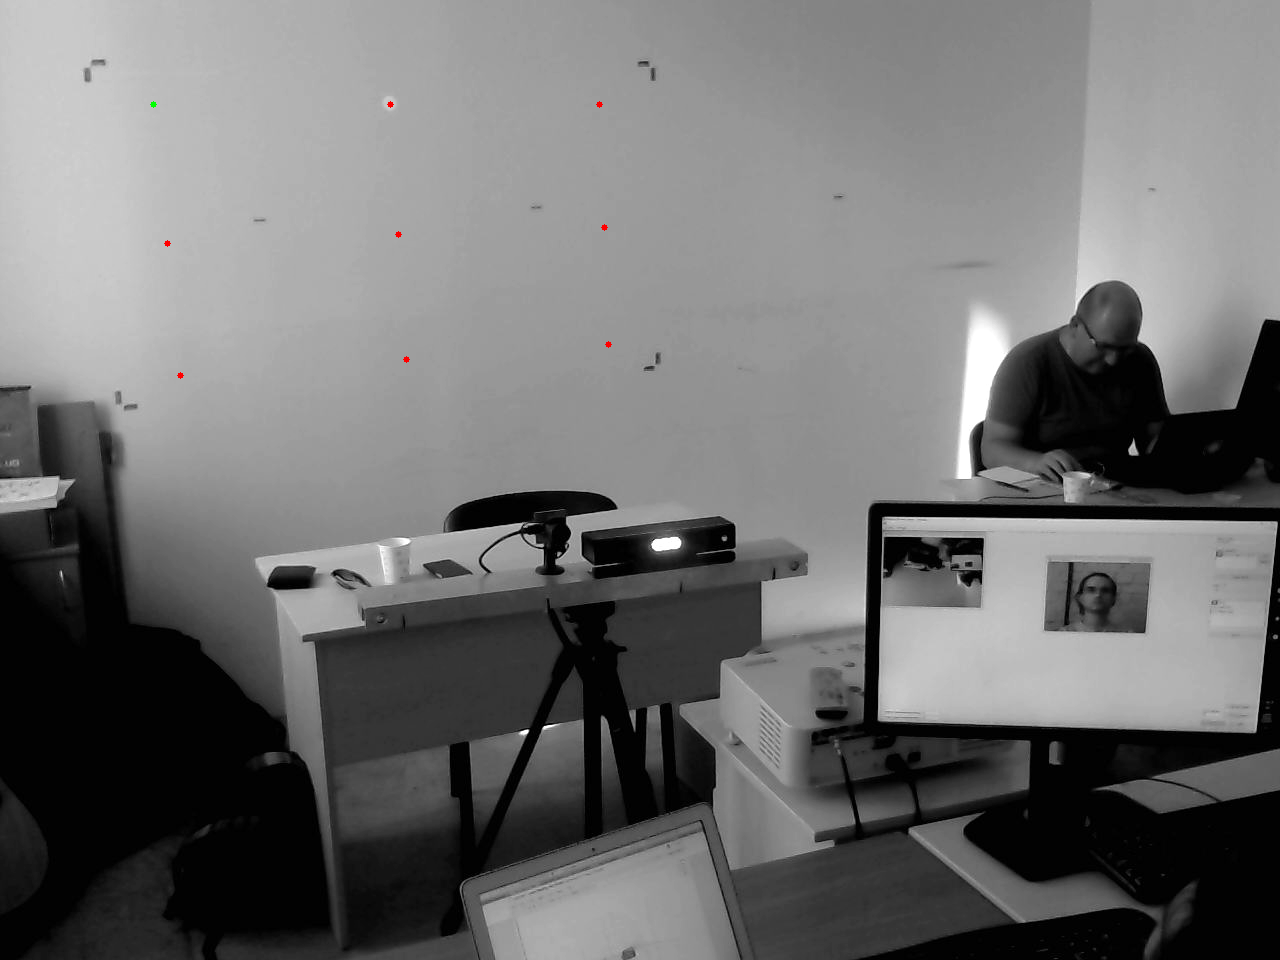

In [130]:
img = np.copy(sess.read_snapshot(100).WebCamera[::-1,::,:])

calibration_points_3d = np.vstack((test_markers, point_gaze.reshape(1, 3)))

# get point in 2d
calibration_points_2d = WebCamera.project_vectors(calibration_points_3d)
print(calibration_points_2d)

for point in calibration_points_2d[:-1]:
    cv2.circle(img, tuple(point.astype(int)), 3, (255, 0, 0), -1)
    
cv2.circle(img, tuple(calibration_points_2d[-1].astype(int)), 3, (0, 255, 0), -1)
Image.fromarray(img)

In [127]:
def plane_line_intersection(line_points, plane_points):

    """
    Compute intersection point of plane and lineself.
    Parameter line_points consists of two points and stands to determine
    line's equesion:
        (x - x_1)/(x_2 - x_1) =
       =(y - y_1)/(y_2 - y_1) =
       =(z - z_1)/(z_2 - z_1).
    Parameter plane_points consists of three points and stands to determine
    plane's equation:
        A*x + B*y + C*z = D.
    This function returns 3D coordinates of intersection point.
    """

    line_point_1 = np.array(line_points[0]).reshape(3)
    line_point_2 = np.array(line_points[1]).reshape(3)
    plane_point_1 = np.array(plane_points[0]).reshape(3)
    plane_point_2 = np.array(plane_points[1]).reshape(3)
    plane_point_3 = np.array(plane_points[2]).reshape(3)

    # These two vectors are in the plane.
    vector_1 = plane_point_3 - plane_point_1
    vector_2 = plane_point_2 - plane_point_1

    # The cross prodaction is a normal vector to the plane.
    cross_product = np.cross(vector_1, vector_2)
    a, b, c = cross_product
    d = np.dot(cross_product, plane_point_3)

    # Compute the solution of equasion A * x = B.
    # Compute matrix A.
    A11 = 1 / (line_point_2[0] - line_point_1[0])
    A12 = -1 / (line_point_2[1] - line_point_1[1])
    A13 = 0
    A21 = 0
    A22 = 1 / (line_point_2[1] - line_point_1[1])
    A23 = -1 / (line_point_2[2] - line_point_1[2])
    A31, A32, A33 = a, b, c
    A = np.array([[A11, A12, A13],
                  [A21, A22, A23],
                  [A31, A32, A33]])

    # Compute vector B.
    B1 = line_point_1[0] * A11 + line_point_1[1] * A12
    B2 = line_point_1[1] * A22 + line_point_1[2] * A23
    B3 = d
    B = np.array([B1, B2, B3])
    
    # Compute intersection point.
    return np.linalg.solve(A, B)

point_gaze = plane_line_intersection(np.stack((right_gazes_true[0]+right_pupil_centers[0], right_pupil_centers[0])),
                        test_markers[[0, 2, -1], :])

In [196]:
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output_test.avi',fourcc, 10.0, (1280, 960))

for i, snapshot in enumerate(test_sess.snapshots_iterate(240, 240+8*10, verbose=True)):
    
    # calculate intersection point
#     point_gaze_true = plane_line_intersection(np.stack((right_gazes_true[i]+right_pupil_centers[i], right_pupil_centers[i])),
#                         test_markers[[0, 2, -1], :])
    point_gaze_pred = plane_line_intersection(np.stack((left_gazes_pred[i]+left_pupil_centers[i], left_pupil_centers[i])),
                        test_markers[[0, 2, -1], :])
    
    # get webcam image
    webcam_img = np.copy(snapshot.WebCamera[::-1,::,:])
    
    # get basler image
    ir_img = np.copy(snapshot.InfraredCamera[:, ::-1, ::])
    
    pupil_2d = InfraredCamera.project_vectors(left_pupil_centers[i].reshape(1, 3))
    
    cv2.circle(ir_img, tuple(pupil_2d[0].astype(int)), 3, (255, 0, 0), -1)
    
    points_to_project = np.vstack((point_gaze_true, point_gaze_pred))
    
    projected_points_to_web = WebCamera.project_vectors(points_to_project)
    
#     gaze_line_true = np.vstack((left_pupil_centers[i], left_gazes_true[i]/10+left_pupil_centers[i]))
    gaze_line_pred = np.vstack((left_pupil_centers[i], left_gazes_pred[i]/10+left_pupil_centers[i]))
    
#     projected_points_to_ir_true = InfraredCamera.project_vectors(gaze_line_true)
    projected_points_to_ir_pred = InfraredCamera.project_vectors(gaze_line_pred)
    
#     pt1_t, pt2_t = projected_points_to_ir_true
    pt1_p, pt2_p = projected_points_to_ir_pred
#     cv2.line(ir_img, tuple(pt1_t.astype(int)), tuple(pt2_t.astype(int)), (255, 0, 0), 3)
    cv2.line(ir_img, tuple(pt1_p.astype(int)), tuple(pt2_p.astype(int)), (0, 0, 255), 3)
    
    ir_resized = cv2.resize(ir_img, (0,0), fx=0.4, fy=0.4)
    
#     cv2.circle(webcam_img, tuple(projected_points_to_web[0].astype(int)), 3, (255, 0, 0), -1)
    cv2.circle(webcam_img, tuple(projected_points_to_web[1].astype(int)), 3, (0, 0, 255), -1)
    
    ir_h, ir_w = ir_resized.shape[:2]
    webcam_img[-ir_h:, 0:ir_w] = ir_resized
    out.write(webcam_img)
    
out.release()
# Image.fromarray(webcam_img)

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:14<00:00,  5.66it/s]


In [142]:
def cost(x, pt2, pt1):
    diff1 = pt2 - pt1
    diff1 = diff1 / np.linalg.norm(diff1, axis=1, keepdims=True)
    diff2 = pt1 - x.reshape(1, 3)
    diff2_norm = np.linalg.norm(diff2, axis=1, keepdims=True)
    diff2 = diff2 / diff2_norm
#     print(diff2_norm)
    return (((diff1 - diff2) ** 2) + 1 * (diff2_norm ** 2)).sum()

right_pupil_centers_person = vectors_to(right_pupil_centers, rotations, translations, 'self')
markers_person = vectors_to(markers, rotations, translations, 'self')
minimized = minimize(cost, right_pupil_centers_person.mean(axis=0), args=(markers_person, right_pupil_centers_person))
print(minimized)
eye_centers_origin = vectors_to(np.tile(minimized.x, (40, 1)), rotations, translations, 'origin')

      fun: 79.14186760368405
 hess_inv: array([[1.03105193e-05, 5.60033323e-07, 2.41722771e-06],
       [5.60033323e-07, 1.07047257e-05, 6.09219627e-06],
       [2.41722771e-06, 6.09219627e-06, 3.10517207e-05]])
      jac: array([9.53674316e-07, 0.00000000e+00, 9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 150
      nit: 13
     njev: 30
   status: 0
  success: True
        x: array([-0.04137574, -0.00767354, -0.01441466])
